In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Quickstart Guide

This guide demonstrates the core functionality of `site_analysis` using a simple example: analysing the diffusion of a single mobile ion through a simple cubic lattice.

## Example Scenario

We'll analyse a short molecular dynamics trajectory where:

1. We have a 4×4×4 simple cubic structure with oxygen atoms at the corners
2. A single mobile lithium ion moves from one interstitial site to an adjacent site
3. We track and analyse this movement using `site_analysis`

For this quickstart, we'll use a pre-generated trajectory (available in the examples directory as `simple_cubic_li.XDATCAR`). This trajectory contains 11 frames showing a lithium ion moving between interstitial sites in a simple cubic structure.

## Loading the Structure and Trajectory

First, let's load our structure and trajectory using pymatgen:

In [ ]:
from pymatgen.io.vasp import Xdatcar
import numpy as np

# Load the trajectory from the XDATCAR file
xdatcar = Xdatcar("examples/simple_cubic_li.XDATCAR")

# Get the structures from the trajectory
structures = xdatcar.structures

# Get the initial structure
structure = structures[0]

print(f"Loaded trajectory with {len(structures)} frames")
print(f"Structure contains {len(structure)} atoms")
print(f"Composition: {structure.composition}")

Let's examine the first structure to understand what we're working with:

In [3]:
# Examine the structure
print(f"Lattice parameters: {structure.lattice.abc}")

# Show the species and their counts
for element, count in structure.composition.items():
    print(f"{element}: {count}")

# Find the position of the Li ion
for i, site in enumerate(structure):
    if site.species_string == "Li":
        print(f"Li ion at index {i}, position: {site.frac_coords}")

Lattice parameters: (16.0, 16.0, 16.0)
O: 64.0
Li: 1.0
Li ion at index 64, position: [0.375 0.375 0.375]


Let's also look at how the Li ion moves during the trajectory:

In [4]:
# Track the Li ion position throughout the trajectory
li_positions = []
for struct in structures:
    for site in struct:
        if site.species_string == "Li":
            li_positions.append(site.frac_coords)
            break
            
# Print the Li positions
print("Li positions throughout trajectory:")
for i, pos in enumerate(li_positions):
    print(f"Frame {i+1}: {pos}")

Li positions throughout trajectory:
Frame 1: [0.375 0.375 0.375]
Frame 2: [0.4   0.375 0.375]
Frame 3: [0.425 0.375 0.375]
Frame 4: [0.45  0.375 0.375]
Frame 5: [0.475 0.375 0.375]
Frame 6: [0.5   0.375 0.375]
Frame 7: [0.525 0.375 0.375]
Frame 8: [0.55  0.375 0.375]
Frame 9: [0.575 0.375 0.375]
Frame 10: [0.6   0.375 0.375]
Frame 11: [0.625 0.375 0.375]


## Defining Sites

Now we'll define the sites we want to track. In this case, we'll create spherical sites at the centers of each unit cell in our simple cubic structure:

In [5]:
from site_analysis import TrajectoryBuilder

# Define the centers of our interstitial sites (at the centers of unit cells)
# For our 4×4×4 structure, we need sites at the centers of each unit cell (4×4×4 sites)
site_centers = []
for i in range(4):
    for j in range(4):
        for k in range(4):
            site_centers.append(np.array([i + 0.5, j + 0.5, k + 0.5])/4)

# Set a radius for each site equal to half the unit cell length (2.0 Å)
# This ensures the sites meet exactly at the boundaries between unit cells
# without overlapping
site_radii = [2.0] * len(site_centers)

# Create labels for the sites (optional but helpful for analysis)
site_labels = [f"Site_{i}_{j}_{k}" for i in range(4) for j in range(4) for k in range(4)]

print(f"Defined {len(site_centers)} interstitial sites")

# Print the first few sites
for i in range(5):
    print(f"Site {i}: center={site_centers[i]}, radius={site_radii[i]}, label={site_labels[i]}")

Defined 64 interstitial sites
Site 0: center=[0.125 0.125 0.125], radius=2.0, label=Site_0_0_0
Site 1: center=[0.125 0.125 0.375], radius=2.0, label=Site_0_0_1
Site 2: center=[0.125 0.125 0.625], radius=2.0, label=Site_0_0_2
Site 3: center=[0.125 0.125 0.875], radius=2.0, label=Site_0_0_3
Site 4: center=[0.125 0.375 0.125], radius=2.0, label=Site_0_1_0


## Creating the Trajectory Analysis

Now let's use the `site_analysis` package to analyse our trajectory. The `TrajectoryBuilder` class provides a convenient way to set up our analysis:

In [6]:
# Use the builder pattern to create our trajectory analysis
trajectory = (TrajectoryBuilder()
             .with_structure(structure)  # Initial structure for reference
             .with_mobile_species("Li")  # Specify which species we're tracking
             .with_spherical_sites(      # Define our spherical interstitial sites
                 centres=site_centers,
                 radii=site_radii,
                 labels=site_labels)
             .build())

# Process the entire trajectory
# The progress=True flag shows a progress bar
trajectory.trajectory_from_structures(structures, progress=True)

print(f"Analysed trajectory of {len(trajectory)} frames")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 2866.92 steps/s]

Analysed trajectory of 11 frames


In [7]:
# 1. Query which site is occupied at the start of the simulation

timestep = 0
first_frame = trajectory.sites_trajectory[timestep]
occupied_sites_start = [i for i, atoms in enumerate(first_frame) if atoms]
if occupied_sites_start:
    start_site = trajectory.site_by_index(occupied_sites_start[0])
    print(f"At the start, {start_site.label} (site index {start_site.index}) is occupied by the Li ion (atom index {start_site.trajectory[timestep][0]})")
else:
    print("No sites occupied at the start")

At the start, Site_1_1_1 (site index 21) is occupied by the Li ion (atom index 64)


In [8]:
# 2. Query which site is occupied at the end of the simulation

timestep = len(trajectory) - 1
last_frame = trajectory.sites_trajectory[timestep]
occupied_sites_end = [i for i, atoms in enumerate(last_frame) if atoms]
if occupied_sites_end:
    end_site = trajectory.site_by_index(occupied_sites_end[0])
    print(f"At the end, {end_site.label} (site index {end_site.index}) is occupied by Li ion (atom index {end_site.trajectory[timestep][0]})")
else:
    print("No sites occupied at the end")

At the end, Site_2_1_1 (site index 37) is occupied by Li ion (atom index 64)


In [9]:
# 3. Query the mobile ion trajectory (site indices over time)

li_atom = trajectory.atoms[0]  # We only have one Li atom
print("Li ion trajectory (site indices over time):")
print(li_atom.trajectory)

Li ion trajectory (site indices over time):
[21, 21, 21, 21, 21, 21, 37, 37, 37, 37, 37]


In [10]:
# 4. Query the trajectories for the two sites involved
# Find the two sites that were ever occupied

ever_occupied_sites = []
for site in trajectory.sites:
    if any(site.trajectory):
        ever_occupied_sites.append(site)
        
print("Trajectories for the occupied sites:")
for site in ever_occupied_sites:
    print(f"{site.label} trajectory: {site.trajectory}")
# This shows when the site was occupied (empty list = unoccupied, list with atom indices = occupied)

Trajectories for the occupied sites:
Site_1_1_1 trajectory: [[64], [64], [64], [64], [64], [64], [], [], [], [], []]
Site_2_1_1 trajectory: [[], [], [], [], [], [], [64], [64], [64], [64], [64]]


In [11]:
# 5. Query the transitions between sites

for site in ever_occupied_sites:
    print(f"{site.label} transitions:")
    if site.transitions:
        for index, number_of_transitions in site.transitions.items():
            print(f"    -> {trajectory.site_by_index(index).label} x {number_of_transitions}.")
    else:
        print(f"    No transitions")
    

Site_1_1_1 transitions:
    -> Site_2_1_1 x 1.
Site_2_1_1 transitions:
    No transitions


## Visualising the Results

For this simple example, a basic visualisation showing the ion movement between the two sites is sufficient:

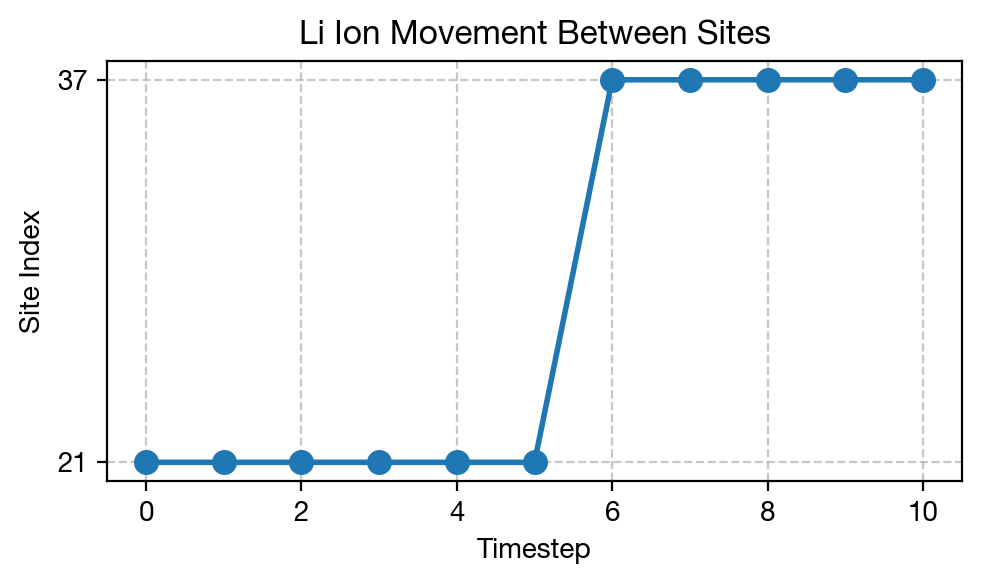

In [12]:
import matplotlib.pyplot as plt

# Visualise the Li ion's site occupation over time
plt.figure(figsize=(5, 3))

# Get the site indices the Li ion occupied at each timestep
li_atom = trajectory.atoms[0]  # We only have one Li atom
site_indices = li_atom.trajectory

# Plot the trajectory
timesteps = range(len(site_indices))
plt.plot(timesteps, site_indices, 'o-', linewidth=2, markersize=8)

# Format the plot
plt.xlabel('Timestep')
plt.ylabel('Site Index')
plt.title('Li Ion Movement Between Sites')
plt.grid(True, linestyle='--', alpha=0.7)
if 'start_site' in locals() and 'end_site' in locals():
    plt.yticks([start_site.index, end_site.index])  # Only show the relevant site indices
plt.tight_layout()
plt.show()

## Alternative Site Types

In the example above, we used spherical sites, which are intuitive but have a key limitation: they do not completely fill space. Even with appropriately sized radii, there will be regions between spheres that are not assigned to any site, and with larger radii, spheres can overlap, resulting in some regions being assigned to multiple sites.

`site_analysis` provides alternative site types that offer complete spatial discretization:

In [13]:
# Example: Using Voronoi sites instead of spherical sites
# Voronoi sites divide space according to proximity to site centres,
# creating a complete tessellation with no gaps or overlaps

# Create a trajectory using Voronoi sites
trajectory = (TrajectoryBuilder()
             .with_structure(structure)  # Initial structure for reference
             .with_mobile_species("Li")  # Specify which species we're tracking
             .with_voronoi_sites(      # Define our spherical interstitial sites
                 centres=site_centers)
             .build())

# Analyse the trajectory
trajectory.trajectory_from_structures(structures, progress=True)

# Compare the Li ion trajectory using Voronoi sites
li_atom_voronoi = trajectory.atoms[0]  # We only have one Li atom
print("Li ion trajectory with Voronoi sites (site indices over time):")
print(li_atom_voronoi.trajectory)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11943.40 steps/s]

Li ion trajectory with Voronoi sites (site indices over time):
[85, 85, 85, 85, 85, 85, 101, 101, 101, 101, 101]


In [ ]:
# Example: Using polyhedral sites for more complex structures
# Polyhedral sites are defined by a set of vertex atoms forming a polyhedron
# and provide a complete spatial discretisation based on the crystal structure

# Create a reference structure with just the framework
reference_structure = structure.copy()
# Remove the Li ion
reference_structure.remove_species(["Li"])
# Add dummy Li ions to every polyhedron centre
for c in site_centers:
    reference_structure.append(species="Li", coords=c)


trajectory = (TrajectoryBuilder()
             .with_structure(structure)  # Initial structure for reference
             .with_reference_structure(reference_structure)
             .with_mobile_species("Li")  # Specify which species we're tracking
             .with_polyhedral_sites(     # Define our spherical interstitial sites
                 centre_species="Li",
                 vertex_species="O",
                 cutoff=4.0,
                 n_vertices=8,
                 label="Cubic")
             .with_structure_alignment(align_species="O")
             .build())

# Analyse the trajectory
trajectory.trajectory_from_structures(structures, progress=True)

# Compare the Li ion trajectory using polyhedral sites
li_atom_poly = trajectory.atoms[0]  # We only have one Li atom
print("Li ion trajectory with polyhedral sites (site indices over time):")
print(li_atom_poly.trajectory)

## Summary

In this quickstart guide, we've:

1. Loaded an existing trajectory of a simple cubic structure with a mobile lithium ion
2. Defined interstitial sites at the centers of the unit cells
3. Used `site_analysis` to track site occupations throughout the trajectory
4. Analyzed the results to understand ion movement patterns
5. Visualized the diffusion pathway and site occupations
6. Demonstrated alternative site types for different analysis scenarios

This demonstrates the core functionality of `site_analysis` for tracking and analyzing ionic diffusion in crystalline materials. The same approach can be extended to more complex structures and longer trajectories with multiple mobile ions.